## Extracting Activations Code

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pipeline to extract activation - Not required if activation is stored

In [3]:
# extract_gpt2_mlp_activations.py
import os
import csv
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from transformers.activations import ACT2FN
import re
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModelForCausalLM
import warnings
warnings.filterwarnings('ignore')


# Load spacy for linguistic features
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Installing spacy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

In [ ]:
# Load model + tokenizer Function
def get_model_tokenizer(model_name = 'gpt2'):

  tokenizer = AutoTokenizer.from_pretrained("gpt2")
  if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token

  model = AutoModelForCausalLM.from_pretrained("gpt2", output_hidden_states=True)

  return tokenizer, model

In [ ]:
tokenizer, model = get_model_tokenizer()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

print(f"Using device: {device}")

Using device: cuda


In [ ]:
blocks=model.transformer.h
blocks

ModuleList(
  (0-11): 12 x GPT2Block(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2Attention(
      (c_attn): Conv1D(nf=2304, nx=768)
      (c_proj): Conv1D(nf=768, nx=768)
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D(nf=3072, nx=768)
      (c_proj): Conv1D(nf=768, nx=3072)
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
LAYER_IDX = 9
sample_block = blocks[LAYER_IDX-1]


# inspect possible names
mlp_dim = sample_block.mlp.c_fc.nf
residual_dim = sample_block.attn.c_proj.nf

print("Residual dimension:", residual_dim)
print("Detected MLP activation dimension:", mlp_dim)

Residual dimension: 768
Detected MLP activation dimension: 3072


In [ ]:
target_layer_id = 9
target_block = blocks[target_layer_id - 1]

# storage
residual_pre_mlp = []
mlp_activations = []
hooks = []
# HOOK 1 — Residual BEFORE MLP
# Output of block BEFORE ln_2 → mlp
# ---------------------------
def hook_residual_pre_mlp(module, input):
    # Fires BEFORE ln_2 forward().
    # The input to ln_2 is exactly: (x + attn_output)
    # = residual stream BEFORE MLP.
    (hidden_states,) = input
    residual_pre_mlp.append(hidden_states.detach().cpu())

# ---------------------------
# HOOK 2 — MLP post-GELU activation
# The activation is the output of c_fc (3072 dims)
# before projection
# ---------------------------
def hook_mlp(module, input, output):
    """
    c_fc produces the 3072-dim pre-GELU activations.
    But HF GPT-2 places GELU *inside GPT2MLP*, not inside c_fc.
    So c_fc output = pre-GELU.
    We must apply GELU manually to get the true MLP activation.
    """
    pre_gelu = output
    post_gelu = torch.nn.functional.gelu(pre_gelu)
    mlp_activations.append(post_gelu.detach().cpu())

# register hooks
residual_handle = target_block.ln_2.register_forward_pre_hook(hook_residual_pre_mlp)
mlp_handle = target_block.mlp.c_fc.register_forward_hook(hook_mlp)

hooks.append(residual_handle)
hooks.append(mlp_handle)

Data Ingestion

In [ ]:
from datasets import load_dataset
from google.colab import drive
drive.mount('/content/drive')
dataset = pd.read_csv("/content/drive/MyDrive/all-data.csv",
                      encoding="latin1",
                      header=None,
                      names=["label", "sentence"])
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,label,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
def get_activations(path,tokenizer,model,device):
  dataset = pd.read_csv(path,encoding="latin1",header=None,names=["label", "sentence"])
  sentences = dataset["sentence"].tolist()
  labels    = dataset["label"].tolist()
  all_activations = []

  for sent in tqdm(sentences):
      # Clear previous activations
      residual_pre_mlp.clear()
      mlp_activations.clear()

      # Tokenize
      inputs = tokenizer(sent, return_tensors="pt").to(device)

      # Forward pass
      with torch.no_grad():
          _ = model(**inputs)

      # Extract tensors (shape: seq_len x hidden_dim)
      res_tensor = residual_pre_mlp[0].squeeze(0)  # 768-dim
      mlp_tensor = mlp_activations[0].squeeze(0)    # 3072-dim

      # Map tokens to activations
      token_dict = {}
      for i, token_id in enumerate(inputs.input_ids[0]):
          token = tokenizer.decode(token_id)
          token_dict[i] = {
              "token": token,
              "residual_pre_mlp": res_tensor[i].numpy(),
              "mlp_post_gelu": mlp_tensor[i].numpy()
          }

      # Append as a tuple
      all_activations.append((sent, token_dict))

  return all_activations

## Structure of all_activations Variable:

all_activations = [
    (sentence_1, { token_index: { token, residual_pre_mlp, mlp_post_gelu }, ... }),
    (sentence_2, { ... }),
    ...
]

## Example of the entry:

[(
  "Earnings this quarter.",
  {
    0: {
        "token": "Earnings",
        "residual_pre_mlp": numpy array of shape (768,),
        "mlp_post_gelu": numpy array of shape (3072,)
    },
    1: {
        "token": " this",
        "residual_pre_mlp": (768,),
        "mlp_post_gelu": (3072,)
    },
    2: {
        "token": " quarter",
        "residual_pre_mlp": (768,),
        "mlp_post_gelu": (3072,)
    },
    3: {
        "token": ".",
        "residual_pre_mlp": (768,),
        "mlp_post_gelu": (3072,)
    }
  }
)]

In [2]:
path="/content/drive/MyDrive/all-data.csv"
all_activations= get_activations(path,tokenizer,model,device)
all_activations[0][1][1].keys()

NameError: name 'get_activations' is not defined

In [ ]:
all_activations[0][0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [ ]:
def save_residuals(all_activations,path):
  residuals_list = []
  mlp_list = []
  tokens_list = []
  sentence_idx_list = []
  position_idx_list = []

  for sent_idx, (sentence, pos_dict) in enumerate(all_activations):
      for pos_idx, token_info in pos_dict.items():
          residuals_list.append(token_info["residual_pre_mlp"])
          mlp_list.append(token_info["mlp_post_gelu"])
          tokens_list.append(token_info["token"])
          sentence_idx_list.append(sent_idx)
          position_idx_list.append(pos_idx)

  # Convert to tensors
  residuals_tensor = torch.tensor(np.stack(residuals_list), dtype=torch.float32)  # total_tokens x 768
  mlp_tensor = torch.tensor(np.stack(mlp_list), dtype=torch.float32)              # total_tokens x 3072
  sentence_idx_tensor = torch.tensor(sentence_idx_list, dtype=torch.long)
  position_idx_tensor = torch.tensor(position_idx_list, dtype=torch.long)
  torch.save({
      "residuals_post_attn": residuals_tensor,
      "tokens": tokens_list,
      "sentence_idx": sentence_idx_tensor,
      "position_idx": position_idx_tensor
  }, path)

In [ ]:
save_residuals(all_activations,"/content/drive/MyDrive/financial_phrasebank_gpt2_1_residuals.pt")

## Key Features Extracted:




### Financial Domain Features:

Sentiment indicators (positive/negative financial terms)
Financial entity detection (revenue, earnings, etc.)
Monetary value and percentage detection

### Activation Statistics:

L2 norms, mean, std, max, min for both residual and MLP activations
Sparsity measures (percentage of near-zero activations)
Top-k activated dimensions


### EMBEDDING-BASED LIKELIHOOD COMPUTATION

In [4]:
# extract_gpt2_mlp_activations.py
import os
import csv
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from transformers.activations import ACT2FN
import re
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModelForCausalLM
import warnings
warnings.filterwarnings('ignore')


# Load spacy for linguistic features
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Installing spacy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

In [5]:
def load_finbert_model():
    """Load FinBERT model for sentiment analysis"""
    print("Loading FinBERT model...")

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    print(f"FinBERT loaded on {device}")

    return tokenizer, model, device

In [6]:
def get_finbert_scores(token, tokenizer, model, device):
    """
    Get FinBERT scores for a single token.
    Financial relevance is approximated as (1 - neutral probability).
    """
    inputs = tokenizer(
        token,
        return_tensors="pt",
        truncation=True,
        max_length=8
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    positive, negative, neutral = probs
    financial_score = 1.0 - neutral

    return {
        'finbert_positive': float(positive),
        'finbert_negative': float(negative),
        'finbert_neutral': float(neutral),
        'finbert_financial': float(financial_score)
    }


In [7]:
def compute_finbert_llr(pos_score, neg_score, neutral_score, corpus_stats):
    """Convert FinBERT probabilities to log-likelihood ratios"""
    epsilon = 1e-6

    financial_score = 1.0 - neutral_score

    llr_positive = np.log(
        max(pos_score, epsilon) / corpus_stats.get('p_sentiment_pos', 0.33)
    )
    llr_negative = np.log(
        max(neg_score, epsilon) / corpus_stats.get('p_sentiment_neg', 0.33)
    )
    llr_financial = np.log(
        max(financial_score, epsilon) / corpus_stats.get('p_financial', 0.5)
    )

    return {
        'finbert_llr_positive': float(llr_positive),
        'finbert_llr_negative': float(llr_negative),
        'finbert_llr_financial': float(llr_financial)
    }


### CORPUS STATISTICS CALCULATION

In [8]:

def calculate_corpus_statistics(sentences):
    # Get domain definitions
    patterns = {
        'money': re.compile(r'\$[\d,]+(?:\.\d+)?[KMB]?'),
        'percent': re.compile(r'\d+(?:\.\d+)?%'),
        'number': re.compile(r'\d+(?:,\d{3})*(?:\.\d+)?')
    }
    sentiment_pos = {
        # Growth & Improvement
        'surge', 'soar', 'jump', 'rise', 'gain', 'increase', 'profit',
        'growth', 'strong', 'beat', 'exceed', 'outperform', 'rally',
        'boom', 'accelerate', 'expand', 'improve', 'robust', 'advance',
        'climb', 'strengthen', 'upturn', 'flourish', 'thrive', 'prosper',

        # Positive Performance
        'successful', 'positive', 'favorable', 'optimistic', 'bullish',
        'upbeat', 'confident', 'encouraging', 'promising', 'bright',
        'healthy', 'solid', 'impressive', 'outstanding', 'excellent',
        'remarkable', 'exceptional', 'record', 'peak', 'milestone',

        # Financial Success
        'profitable', 'lucrative', 'beneficial', 'advantageous',
        'productive', 'effective', 'efficient', 'success', 'achieving',
        'achieved', 'breakthrough', 'triumph', 'victory', 'winning',

        # Market Momentum
        'momentum', 'upward', 'upgrade', 'boosted', 'elevated',
        'enhanced', 'enriched', 'bolstered', 'reinforced', 'amplified',
        'maximized', 'optimized', 'revitalized', 'recovered', 'rebound',

        # Comparative Advantage
        'better', 'superior', 'leading', 'dominant', 'competitive',
        'ahead', 'top', 'best', 'highest', 'greater', 'more',
        'above', 'over', 'beyond', 'surpass', 'overtake'
    }
    sentiment_neg = {
        # Decline & Loss
        'plunge', 'drop', 'fall', 'decline', 'loss', 'decrease', 'weak',
        'miss', 'underperform', 'slump', 'crash', 'tumble', 'collapse',
        'shrink', 'deteriorate', 'worsen', 'struggle', 'plummet', 'sink',
        'slide', 'weaken', 'downturn', 'downward', 'falling', 'declining',

        # Negative Performance
        'unsuccessful', 'negative', 'unfavorable', 'pessimistic', 'bearish',
        'disappointing', 'discouraging', 'concerning', 'troubling', 'worrying',
        'poor', 'bad', 'terrible', 'awful', 'worst', 'lowest',

        # Financial Distress
        'unprofitable', 'deficit', 'shortfall', 'losses', 'losing',
        'bankruptcy', 'bankrupt', 'insolvent', 'debt', 'liability',
        'default', 'failure', 'failed', 'failing', 'struggling',

        # Market Weakness
        'volatile', 'volatility', 'unstable', 'uncertain', 'uncertainty',
        'risk', 'risky', 'danger', 'threat', 'threatened', 'vulnerable',
        'exposed', 'weakness', 'fragile', 'precarious', 'crisis',

        # Contraction
        'contraction', 'reduction', 'cut', 'cutting', 'slash', 'slashing',
        'layoff', 'layoffs', 'downsize', 'downsizing', 'closure', 'closing',
        'shutdown', 'suspend', 'halt', 'stop', 'ceased', 'terminated',

        # Comparative Disadvantage
        'worse', 'inferior', 'lagging', 'trailing', 'behind',
        'below', 'under', 'beneath', 'less', 'lower', 'fewer',
        'minimal', 'insufficient', 'inadequate', 'subpar'
    }
    financial_entities = {
        # Income Statement Items
        'revenue', 'revenues', 'sales', 'income', 'earnings', 'profit',
        'profits', 'loss', 'losses', 'margin', 'margins', 'ebitda',
        'ebit', 'eps', 'operating', 'gross', 'net',

        # Balance Sheet Items
        'asset', 'assets', 'liability', 'liabilities', 'equity',
        'debt', 'capital', 'cash', 'inventory', 'receivables',
        'payables', 'goodwill', 'intangible', 'tangible',

        # Cash Flow
        'cashflow', 'flow', 'flows', 'fcf', 'ocf', 'capex',
        'expenditure', 'expenditures', 'investment', 'investments',

        # Market & Trading
        'stock', 'stocks', 'share', 'shares', 'price', 'prices',
        'market', 'markets', 'trading', 'volume', 'valuation',
        'cap', 'capitalization', 'ticker', 'equity',

        # Returns & Yields
        'dividend', 'dividends', 'yield', 'return', 'returns',
        'roe', 'roa', 'roi', 'irr', 'wacc', 'beta',

        # Ratios & Metrics
        'ratio', 'ratios', 'multiple', 'multiples', 'pe', 'pb',
        'ps', 'ev', 'peg', 'current', 'quick', 'leverage',

        # Financial Periods
        'quarter', 'quarterly', 'annual', 'yearly', 'fiscal',
        'ytd', 'yoy', 'qoq', 'mom', 'q1', 'q2', 'q3', 'q4',
        'fy', 'h1', 'h2', 'year', 'period',

        # Financial Statements
        'statement', 'statements', 'balance', 'sheet', 'report',
        'reporting', 'filing', 'disclosure', 'sec', '10k', '10q',

        # Accounting Terms
        'depreciation', 'amortization', 'accrual', 'provision',
        'reserve', 'reserves', 'writedown', 'writeoff', 'impairment',
        'revaluation', 'adjustment', 'gaap', 'ifrs',

        # Corporate Actions
        'merger', 'acquisition', 'buyback', 'repurchase', 'ipo',
        'offering', 'issuance', 'split', 'spinoff', 'divestiture',

        # Valuation Terms
        'dcf', 'npv', 'wacc', 'capm', 'terminal', 'perpetuity',
        'discount', 'rate', 'growth', 'forecast', 'projection',

        # Business Segments
        'segment', 'division', 'unit', 'subsidiary', 'operation',
        'operations', 'business', 'enterprise', 'firm', 'company',
        'corporation', 'organization',

        # Performance Indicators
        'kpi', 'metric', 'metrics', 'performance', 'benchmark',
        'target', 'guidance', 'outlook', 'forecast', 'estimate',
        'consensus', 'analyst', 'analysts',

        # Banking & Finance
        'loan', 'loans', 'credit', 'financing', 'refinancing',
        'borrowing', 'lending', 'interest', 'rate', 'rates',
        'libor', 'prime', 'spread', 'yield', 'bond', 'bonds',

        # Risk & Compliance
        'risk', 'compliance', 'regulation', 'regulatory', 'audit',
        'auditor', 'control', 'controls', 'governance', 'oversight',

        # Investment Terms
        'portfolio', 'fund', 'funds', 'hedge', 'private', 'venture',
        'pe', 'vc', 'allocation', 'diversification', 'exposure',

        # Currency & Commodities
        'currency', 'forex', 'fx', 'exchange', 'commodity',
        'commodities', 'derivatives', 'futures', 'options', 'swap',

        # Economic Indicators
        'gdp', 'inflation', 'cpi', 'ppi', 'unemployment',
        'interest', 'fed', 'federal', 'reserve', 'central', 'bank'
    }

    # Initialize counters
    total_tokens = 0
    count_financial = 0
    count_sentiment_pos = 0
    count_sentiment_neg = 0
    count_monetary = 0
    count_percentage = 0
    count_numeric = 0
    count_punctuation = 0

    print("Calculating corpus statistics...")
    for sent in tqdm(sentences, desc="Processing sentences"):
        # Simple whitespace tokenization (approximate)
        tokens = str(sent).split()
        total_tokens += len(tokens)

        for token in tokens:
            token_lower = token.lower().strip()

            # Check each category
            if token_lower in financial_entities:
                count_financial += 1

            if token_lower in sentiment_pos:
                count_sentiment_pos += 1

            if token_lower in sentiment_neg:
                count_sentiment_neg += 1

            if patterns['money'].match(token):
                count_monetary += 1

            if patterns['percent'].match(token):
                count_percentage += 1

            if patterns['number'].match(token):
                count_numeric += 1

            if token.strip() in '.,;:!?':
                count_punctuation += 1

    # Calculate probabilities with smoothing
    epsilon = 1e-6  # Avoid division by zero
    corpus_stats = {
        'p_financial': max(count_financial / total_tokens, epsilon),
        'p_sentiment_pos': max(count_sentiment_pos / total_tokens, epsilon),
        'p_sentiment_neg': max(count_sentiment_neg / total_tokens, epsilon),
        'p_monetary': max(count_monetary / total_tokens, epsilon),
        'p_percentage': max(count_percentage / total_tokens, epsilon),
        'p_numeric': max(count_numeric / total_tokens, epsilon),
        'p_punctuation': max(count_punctuation / total_tokens, epsilon)
    }

    return corpus_stats

### Linguistic Features:

POS tags and dependency relations via spaCy
Named entity recognition
Stop word identification

In [9]:
def extract_linguistic_features(sentence, token_features_list):
    doc = nlp(sentence)
    spacy_tokens = [t for t in doc]

    for token_feat in token_features_list:
        token_text = token_feat['token_text'].strip()

        # Find matching spaCy token
        matched_spacy = None
        for st in spacy_tokens:
            if st.text.lower() == token_text.lower():
                matched_spacy = st
                break

        if matched_spacy:
            token_feat['pos_tag'] = matched_spacy.pos_
            token_feat['dep_relation'] = matched_spacy.dep_
            token_feat['is_entity'] = matched_spacy.ent_type_ != ''
            token_feat['entity_type'] = matched_spacy.ent_type_
            token_feat['is_stop_word'] = matched_spacy.is_stop
        else:
            # Default values if no match
            token_feat['pos_tag'] = 'UNK'
            token_feat['dep_relation'] = 'UNK'
            token_feat['is_entity'] = False
            token_feat['entity_type'] = ''
            token_feat['is_stop_word'] = False

    return token_features_list

In [10]:
def compute_activation_stats(vector, prefix='residual'):
    return {
        f'{prefix}_l2_norm': float(np.linalg.norm(vector)),
        f'{prefix}_mean': float(np.mean(vector)),
        f'{prefix}_std': float(np.std(vector)),
        f'{prefix}_max': float(np.max(vector)),
        f'{prefix}_min': float(np.min(vector)),
        f'{prefix}_sparsity': float(np.mean(np.abs(vector) < 0.01)),
        f'{prefix}_top5_dims': np.argsort(np.abs(vector))[-5:].tolist()
    }

### Contextual Features:

Position information (absolute and relative)
Distance to nearest financial entities
Token type classification

In [11]:
def calculate_distance_to_financial(position, sent_tokens, financial_entities):
    sent_lower = [t.lower().strip() for t in sent_tokens]
    financial_positions = [i for i, t in enumerate(sent_lower)
                          if t in financial_entities]

    if financial_positions:
        return min(abs(position - fp) for fp in financial_positions)
    else:
        return len(sent_tokens)


### MAIN FEATURE EXTRACTION

In [12]:

def extract_token_features(token_text, position, total_tokens, sent_tokens,
                          residual_vec, mlp_vec, corpus_stats,
                          finbert_scores):  # NEW PARAMETER
    """Extract all features including FinBERT scores"""

    # Get domain definitions (keeping your existing lists)
    patterns = {
        'money': re.compile(r'\$[\d,]+(?:\.\d+)?[KMB]?'),
        'percent': re.compile(r'\d+(?:\.\d+)?%'),
        'number': re.compile(r'\d+(?:,\d{3})*(?:\.\d+)?')
    }

    # [Include your full sentiment_pos, sentiment_neg, financial_entities sets here]
    sentiment_pos = set()  # Your full set
    sentiment_neg = set()  # Your full set
    financial_entities = set()  # Your full set

    features = {
        'token_text': token_text,
        'token_lower': token_text.lower().strip(),
        'position': position,
        'relative_position': position / max(total_tokens - 1, 1),
        'token_length': len(token_text)
    }

    # ADD FINBERT SCORES (sentence-level, applied to all tokens)
    features.update(finbert_scores)

    # Add contextual distance
    features['distance_to_nearest_financial'] = calculate_distance_to_financial(
        position, sent_tokens, financial_entities
    )

    # Add activation statistics
    features.update(compute_activation_stats(residual_vec, 'residual'))
    features.update(compute_activation_stats(mlp_vec, 'mlp'))



    return features

### Data Load and Processing

In [40]:
# Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader

In [41]:
class ResidualDataset(Dataset):
    def __init__(self, data):
        self.residuals = data["residuals_post_attn"]
        self.tokens = data["tokens"]
        self.sentence_idx = data["sentence_idx"]
        self.position_idx = data["position_idx"]

    def __len__(self):
        return self.residuals.shape[0]

    def __getitem__(self, idx):
        return {
            "activations": self.residuals[idx],
            "token": self.tokens[idx],
            "sentence_idx": self.sentence_idx[idx],
            "position_idx": self.position_idx[idx],
        }

In [78]:

def load_and_group(residuals_path):
    print(f"Loading residuals from {residuals_path}...")
    data = torch.load(residuals_path, weights_only=False)
    loader = DataLoader(data, batch_size=128, shuffle=False)

    # Collect all batches
    all_residuals = []
    all_tokens = []
    all_sentence_idx = []
    all_position_idx = []
    all_mlp = []

    for batch in loader:
        if batch.get("activations", None) is not None:
            all_residuals.append(batch["activations"])
        all_tokens.extend(batch["token"])
        all_sentence_idx.append(batch["sentence_idx"])
        all_position_idx.append(batch["position_idx"])
        if batch.get("mlp_post_gelu", None) is not None:
            all_mlp.append(batch["mlp_post_gelu"])

    # Concatenate all batches into single tensors
    residuals_tensor = torch.cat(all_residuals, dim=0) if all_residuals else None
    tokens_list = all_tokens
    sentence_idx_tensor = torch.cat(all_sentence_idx, dim=0)
    position_idx_tensor = torch.cat(all_position_idx, dim=0)
    mlp_tensor = torch.cat(all_mlp, dim=0) if all_mlp else None

    if mlp_tensor is None:
        print("Warning: MLP activations not found. Will use zeros.")
        mlp_tensor = torch.zeros(len(tokens_list), 3072)

    print(f"Loaded {len(tokens_list)} tokens from "
          f"{len(set(sentence_idx_tensor.tolist()))} sentences")

    data =  {'residuals': residuals_tensor,'mlp': mlp_tensor,'tokens': tokens_list,'sentence_idx': sentence_idx_tensor,'position_idx': position_idx_tensor}
    sentence_groups = {}

    for idx in range(len(data['tokens'])):
        sent_idx = data['sentence_idx'][idx].item()
        pos_idx = data['position_idx'][idx].item()

        if sent_idx not in sentence_groups:
            sentence_groups[sent_idx] = []

        sentence_groups[sent_idx].append({
            'global_idx': idx,
            'position': pos_idx,
            'token': data['tokens'][idx],
            'residual': data['residuals'][idx].numpy(),
            'mlp': data['mlp'][idx].numpy()
        })

    # Sort each sentence's tokens by position
    for sent_idx in sentence_groups:
        sentence_groups[sent_idx].sort(key=lambda x: x['position'])
    return sentence_groups


In [79]:
def process_sentence_tokens(tokens_in_sent, sent_idx, sentence_text,
                           corpus_stats, finbert_scores):
    """Process tokens with FinBERT scores"""
    sent_tokens = [t['token'] for t in tokens_in_sent]
    total_tokens = len(sent_tokens)

    token_features = []

    for token_info in tokens_in_sent:
        features = extract_token_features(
            token_text=token_info['token'],
            position=token_info['position'],
            total_tokens=total_tokens,
            sent_tokens=sent_tokens,
            residual_vec=token_info['residual'],
            mlp_vec=token_info['mlp'],
            corpus_stats=corpus_stats,
            finbert_scores=finbert_scores  # Pass FinBERT scores
        )

        features['sentence_idx'] = sent_idx
        features['global_token_idx'] = token_info['global_idx']
        features['residual_vector'] = token_info['residual']
        features['mlp_vector'] = token_info['mlp']

        token_features.append(features)

    return token_features

In [80]:
def process_all_sentences(sentence_groups, sentences_df, corpus_stats, finbert_tokenizer, finbert_model, finbert_device):
    """Process all sentences with FinBERT"""
    all_features = []

    for sent_idx in tqdm(sorted(sentence_groups.keys()), desc="Extracting features"):
        tokens_in_sent = sentence_groups[sent_idx]

        # Get sentence text
        sentence_text = None
        if sent_idx < len(sentences_df):
            sentence_text = sentences_df.iloc[sent_idx]['sentence']

        if sentence_text is None:
            continue

        # Get FinBERT scores for this sentence
        finbert_scores = get_finbert_scores(sentence_text, finbert_tokenizer,
                                            finbert_model, finbert_device)

        # Compute FinBERT LLR
        finbert_llr = compute_finbert_llr(
            finbert_scores['finbert_positive'],
            finbert_scores['finbert_negative'],
            finbert_scores['finbert_neutral'],
            corpus_stats
        )

        # Combine scores
        finbert_features = {**finbert_scores, **finbert_llr}

        # Process tokens with FinBERT features
        token_features = process_sentence_tokens(
            tokens_in_sent, sent_idx, sentence_text,
            corpus_stats, finbert_features
        )

        all_features.extend(token_features)

    return all_features

In [81]:
def features_to_dataframe(all_features):
    # Separate scalar features from vectors
    scalar_features = []
    for feat in all_features:
        scalar_feat = {k: v for k, v in feat.items()
                      if k not in ['residual_vector', 'mlp_vector']}
        scalar_features.append(scalar_feat)

    df = pd.DataFrame(scalar_features)

    # Store vectors separately
    vectors = {
        'residual': np.stack([f['residual_vector'] for f in all_features]),
        'mlp': np.stack([f['mlp_vector'] for f in all_features])
    }

    return df, vectors

### Main Pipeline

In [82]:
def load_and_extract_features_with_finbert(residuals_path, sentences_df, corpus_stats,
                                          embedding_cache='financial_embeddings.model'):
    """
    Main extraction function with FinBERT integration

    Returns:
        df: DataFrame with all features including FinBERT
        vectors: Dict with activation vectors
        embedding_model: Trained Word2Vec model
    """

    # Load FinBERT
    finbert_tokenizer, finbert_model, finbert_device = load_finbert_model()


    # Load and group residuals
    sentence_groups = load_and_group(residuals_path)

    # Process all sentences with FinBERT
    all_features = process_all_sentences(
        sentence_groups, sentences_df, corpus_stats, finbert_tokenizer, finbert_model, finbert_device
    )

    # Convert to DataFrame
    df, vectors = features_to_dataframe(all_features)

    print(f"\nExtracted features for {len(df)} tokens")
    print(f"Feature columns: {len(df.columns)}")
    print(f"FinBERT features: ENABLED")

    return df, vectors

### TESTING

In [83]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SLDS_Project/data/all-data.csv",
                      encoding="latin1",
                      header=None,
                      names=["label", "sentence"])

# Calculate corpus statistics
corpus_stats = calculate_corpus_statistics(dataset['sentence'])

# Extract features with FinBERT
df, vectors = load_and_extract_features_with_finbert(
    residuals_path="/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/phrase_gpt2_l9_test.pt",
    sentences_df=dataset,
    corpus_stats=corpus_stats
)

Calculating corpus statistics...


Processing sentences: 100%|██████████| 4846/4846 [00:00<00:00, 34163.94it/s]

Loading FinBERT model...


FinBERT loaded on cpu
Loading residuals from /content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/phrase_gpt2_l9_test.pt...
Loaded 13841 tokens from 4365 sentences


Extracting features: 100%|██████████| 4365/4365 [07:09<00:00, 10.16it/s]



Extracted features for 13841 tokens
Feature columns: 29
FinBERT features: ENABLED


In [95]:
df.head(10)

,token_text,token_lower,position,relative_position,token_length,finbert_positive,finbert_negative,finbert_neutral,finbert_financial,finbert_llr_positive,...,residual_top5_dims,mlp_l2_norm,mlp_mean,mlp_std,mlp_max,mlp_min,mlp_sparsity,mlp_top5_dims,sentence_idx,global_token_idx
0,where,where,19,19.00,6,0.058360,0.026259,0.915380,0.084620,1.721618,...,"[393, 481, 373, 64, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",0,1766
1,to,to,3,1.50,3,0.386299,0.006671,0.607030,0.392970,3.611598,...,"[393, 64, 481, 373, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",1,142
2,to,to,20,10.00,3,0.386299,0.006671,0.607030,0.392970,3.611598,...,"[393, 64, 481, 373, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",1,3550
3,the,the,30,15.00,4,0.386299,0.006671,0.607030,0.392970,3.611598,...,"[393, 64, 481, 373, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",1,1032
4,The,the,0,0.00,3,0.044339,0.016847,0.938813,0.061187,1.446861,...,"[674, 481, 378, 138, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",2,574
5,q,q,8,2.00,1,0.044339,0.016847,0.938813,0.061187,1.446861,...,"[266, 64, 373, 481, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",2,7616
6,the,the,25,6.25,4,0.044339,0.016847,0.938813,0.061187,1.446861,...,"[393, 64, 481, 373, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",2,89
7,ranks,ranks,29,7.25,6,0.044339,0.016847,0.938813,0.061187,1.446861,...,"[266, 64, 373, 481, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",2,5237
8,.,.,41,10.25,2,0.044339,0.016847,0.938813,0.061187,1.446861,...,"[640, 64, 373, 481, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",2,2348
9,to,to,11,5.50,3,0.242263,0.008450,0.749287,0.250713,3.145008,...,"[393, 481, 64, 373, 447]",0.0,0.0,0.0,0.0,0.0,1.0,"[20, 19, 18, 17, 16]",3,8219


In [85]:
df.shape

(13841, 29)

In [92]:
# Explore the data
financial_tokens=df[df['finbert_financial']>1]

In [93]:
### Store text
# df.to_csv("/content/drive/MyDrive/Colab Notebooks/SLDS_Project/test_financial_score.csv", index=False)

In [94]:
financial_tokens.head(10)

,token_text,token_lower,position,relative_position,token_length,finbert_positive,finbert_negative,finbert_neutral,finbert_financial,finbert_llr_positive,...,residual_top5_dims,mlp_l2_norm,mlp_mean,mlp_std,mlp_max,mlp_min,mlp_sparsity,mlp_top5_dims,sentence_idx,global_token_idx


In [23]:
financial_tokens["finbert_llr_financial"].value_counts()

,count
finbert_llr_financial,
2.731551,306
2.112704,202
2.720408,176
2.239170,148
2.312533,147
...,...
2.725743,7
2.696240,6
2.733432,6


## Analyzing Features

In [24]:
import matplotlib.pyplot as plt

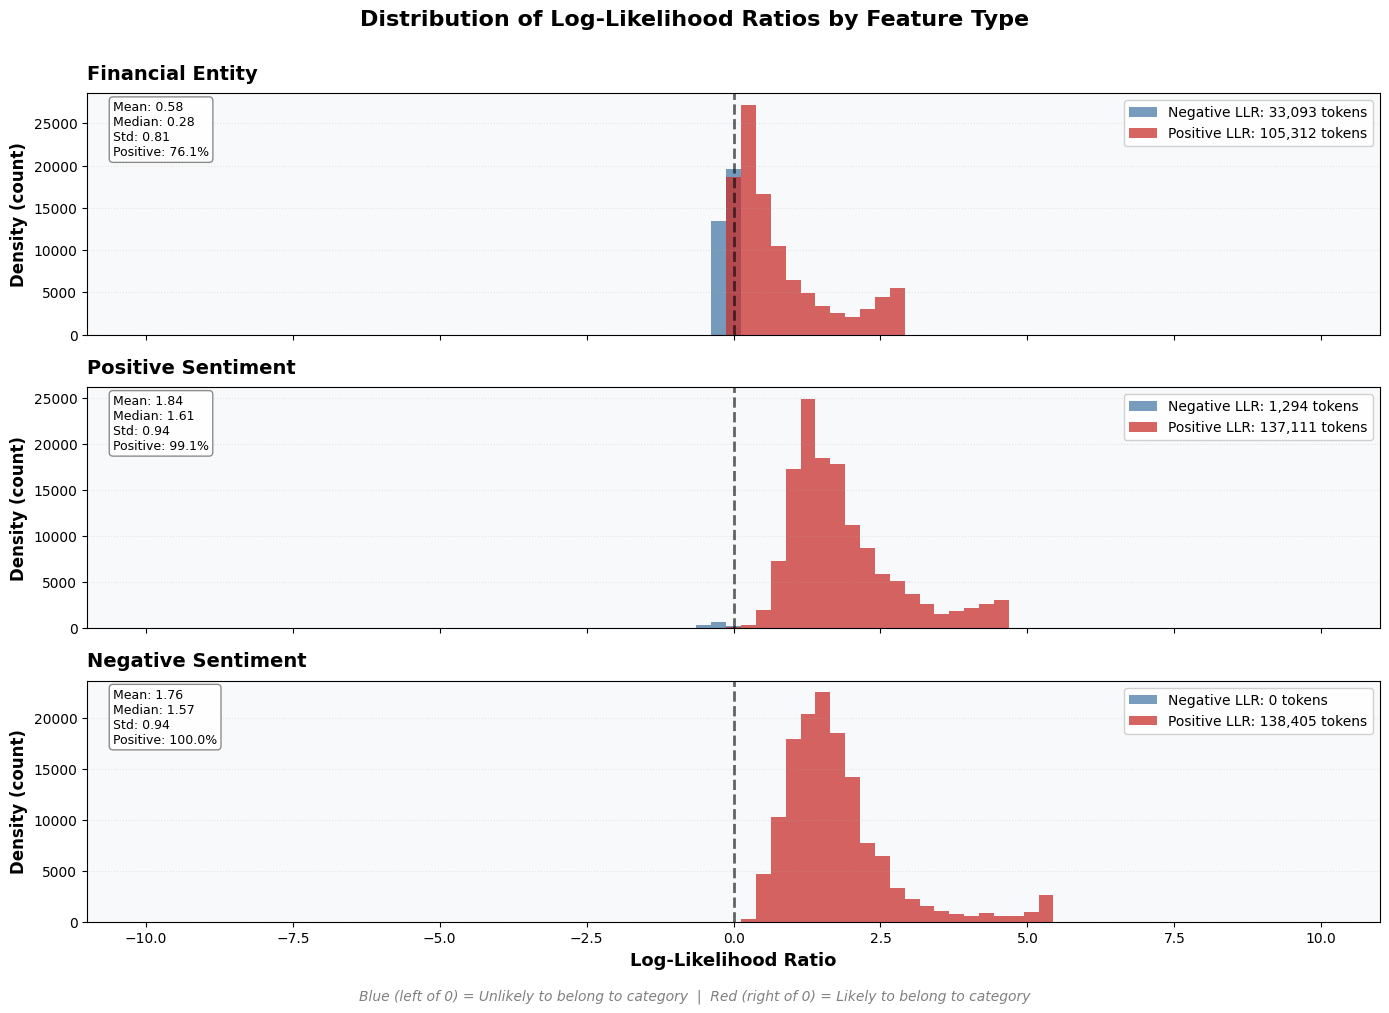


LOG-LIKELIHOOD RATIO SUMMARY STATISTICS

Financial Entity:
  Total tokens in vocab: 138,405
  Mean: 0.579
  Median: 0.282
  Std Dev: 0.810
  Min: -0.345
  Max: 2.744
  Positive LLR (likely): 105,312 (76.1%)
  Negative LLR (unlikely): 33,093 (23.9%)

Positive Sentiment:
  Total tokens in vocab: 138,405
  Mean: 1.837
  Median: 1.609
  Std Dev: 0.939
  Min: -0.461
  Max: 4.524
  Positive LLR (likely): 137,111 (99.1%)
  Negative LLR (unlikely): 1,294 (0.9%)

Negative Sentiment:
  Total tokens in vocab: 138,405
  Mean: 1.758
  Median: 1.575
  Std Dev: 0.940
  Min: 0.305
  Max: 5.354
  Positive LLR (likely): 138,405 (100.0%)
  Negative LLR (unlikely): 0 (0.0%)



In [25]:
# Filter to tokens in vocabulary

# Define features
features = {
    'Financial Entity': 'finbert_llr_financial',
    'Positive Sentiment': 'finbert_llr_positive',
    'Negative Sentiment': 'finbert_llr_negative'
}

# Create figure with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for idx, (feature_name, col_name) in enumerate(features.items()):
    ax = axes[idx]

    # Get LLR data
    llr_values = df[col_name].values
    llr_values = np.clip(llr_values, -10, 10)  # Clip extreme values

    # Split by sign for coloring
    negative = llr_values[llr_values <= 0]
    positive = llr_values[llr_values > 0]

    # Create bins
    bins = np.linspace(-10, 10, 80)

    # Plot histograms
    ax.hist(negative, bins=bins, color='#4A7BA7', alpha=0.75,
            label=f'Negative LLR: {len(negative):,} tokens',
            edgecolor='none')
    ax.hist(positive, bins=bins, color='#C9302C', alpha=0.75,
            label=f'Positive LLR: {len(positive):,} tokens',
            edgecolor='none')

    # Vertical line at 0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.6)

    # Styling
    ax.set_ylabel('Density (count)', fontsize=12, fontweight='bold')
    ax.set_title(feature_name, fontsize=14, fontweight='bold', loc='left', pad=10)
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y', linestyle=':')
    ax.set_facecolor('#F8F9FA')

    # Add statistics box
    mean_val = np.mean(llr_values)
    median_val = np.median(llr_values)
    std_val = np.std(llr_values)
    pct_positive = 100 * len(positive) / len(llr_values)

    stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nPositive: {pct_positive:.1f}%'
    ax.text(0.02, 0.97, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

# X-axis label only on bottom plot
axes[-1].set_xlabel('Log-Likelihood Ratio', fontsize=13, fontweight='bold')

# Overall title
fig.suptitle('Distribution of Log-Likelihood Ratios by Feature Type',
             fontsize=16, fontweight='bold', y=0.995)

# Add note at bottom
fig.text(0.5, 0.005,
         'Blue (left of 0) = Unlikely to belong to category  |  Red (right of 0) = Likely to belong to category',
         ha='center', fontsize=10, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.02, 1, 0.99])
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("LOG-LIKELIHOOD RATIO SUMMARY STATISTICS")
print("="*70)

for feature_name, col_name in features.items():
    values = df[col_name].values
    print(f"\n{feature_name}:")
    print(f"  Total tokens in vocab: {len(values):,}")
    print(f"  Mean: {np.mean(values):.3f}")
    print(f"  Median: {np.median(values):.3f}")
    print(f"  Std Dev: {np.std(values):.3f}")
    print(f"  Min: {np.min(values):.3f}")
    print(f"  Max: {np.max(values):.3f}")
    print(f"  Positive LLR (likely): {(values > 0).sum():,} ({100*(values > 0).sum()/len(values):.1f}%)")
    print(f"  Negative LLR (unlikely): {(values <= 0).sum():,} ({100*(values <= 0).sum()/len(values):.1f}%)")

print("\n" + "="*70)
